In [1]:
import pathlib
import pandas as pd 
import numpy as np 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer 
import re 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
dataset = pathlib.Path.cwd() / 'train.tsv'
df = pd.read_csv(dataset, sep='\t', header=None, names=['comment', 'label', 'id'])
df['label'] = df['label'].str.split(',')

<h3>Mapping Label</h3>

In [3]:
# Melakukan mapping 27 label menjadi 7 label
emotion_list = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment',                     
                'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',                 
                'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

enkman_mapping = {
        "anger": ["anger", "annoyance", "disapproval"],
        "disgust": ["disgust"],
        "fear": ["fear", "nervousness"],
        "joy": ["joy", "amusement", "approval", "excitement", "gratitude",  "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
        "sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
        "surprise": ["surprise", "realization", "confusion", "curiosity"],
        "neutral": ["neutral"],
        }
enkman_mapping_rev = {v:key for key, value in enkman_mapping.items() for v in value}

In [4]:
# function from Google Research analysis 
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

In [5]:
# add emotion label to the label ids
df['emotions'] = df['label'].apply(idx2class)

# use enkman mapping to reduce the emotions to a list of ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
df['mapped_emotions'] = df['emotions'].apply(lambda x: [enkman_mapping_rev[i] for i in x])

# fix issues where ['joy',' joy'] might appear
df.loc[df['mapped_emotions'].apply(len)>1, 'mapped_emotions'] = df.loc[df['mapped_emotions'].apply(len)>1, 'mapped_emotions'].apply(lambda x: [emotion for emotion in set(x)])

<h3>Data Preprocessing</h3>

In [6]:
import re
import string
import json
!pip install emoji
import emoji
import numpy as np
import pandas as pd

In [7]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [8]:
stemmer = PorterStemmer()
stopword_list = stopwords.words('english')

def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def tokenize_stem_no_stopwords(text):
    return [stemmer.stem(w) for w in word_tokenize(text) if w not in stopword_list]

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    text = tokenize_stem_no_stopwords(text)
    return text

In [9]:
df['processed_comment'] = df['comment'].str.lower()
df['processed_comment'] = df['processed_comment'].apply(text_preprocessing_pipeline)

In [10]:
N = df.shape[0]
for emotion in enkman_mapping.keys():
    df[emotion] = np.zeros((N,1), dtype=int)

for emotion in enkman_mapping.keys():
    df[emotion] = df['mapped_emotions'].apply(lambda x: 1 if emotion in x else 0)

In [11]:
X_train, X_test = train_test_split(df, random_state=156, test_size=0.25, shuffle=True)

In [12]:
tfidf=TfidfVectorizer()

x_train = tfidf.fit_transform(X_train['processed_comment'].apply(lambda x: ' '.join(x)))
x_test = tfidf.transform(X_test['processed_comment'].apply(lambda x: ' '.join(x)))

In [13]:
X_train.head()

,comment,label,id,emotions,mapped_emotions,processed_comment,anger,disgust,fear,joy,sadness,surprise,neutral
16737,"It’s time to stop lad, it’s getting a little e...",[12],ef64or1,[embarrassment],[sadness],"[time, stop, lad, get, littl, embarrass]",0,0,0,0,1,0,0
5935,So glad my mom didn’t act this way when I was ...,"[0, 17]",ediz2sg,"[admiration, joy]",[joy],"[glad, mom, act, way, diagnos, oh, mom, smart,...",0,0,0,1,0,0,0
20213,Hopefully that's patched soon.,[20],edmb4z7,[optimism],[joy],"[hope, patch, soon]",0,0,0,1,0,0,0
1147,If you want a one minute story told in half an...,[1],eedcfbk,[amusement],[joy],"[want, one, minut, stori, told, half, hour, as...",0,0,0,1,0,0,0
29277,[NAME] has 6 eyes and will thus be the best ac...,[27],edki307,[neutral],[neutral],"[eye, thu, best, actor, movi]",0,0,0,0,0,0,1


In [14]:
data = X_train.sample(frac =0.2)

In [15]:
from sklearn.model_selection import train_test_split
X = data['comment'].values
X= X.astype(str)
y = data.iloc[:,6:].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [16]:
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split
# !pip install --user keras
# !pip install --user tensorflow
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense,Flatten,LSTM,Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import model_from_json
from keras.models import load_model

pd.set_option('display.max_colwidth', 200)

tokenizer = Tokenizer() #make a tokenizer
tokenizer.fit_on_texts(X_train) #fit on text


num_words=7000
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= num_words} # <= because tokenizer is 1 indexed
tokenizer.word_index[tokenizer.oov_token] = num_words + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = 20
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [17]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index)+1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath,encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix
    
embedding_dim = 300
embedding_matrix = create_embedding_matrix('glove.6B.300d.txt', tokenizer.word_index, embedding_dim)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
embedding_accuracy = nonzero_elements / vocab_size
print('embedding accuracy: ' + str(embedding_accuracy))

embedding accuracy: 0.8961725221365324


<h3>Model Building</h3>

In [18]:
# create the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
    
model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(7, activation='softmax'))
# Adam Optimiser
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 300)           2100600   
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               1140736   
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 3,307,903
Trainable params: 3,307,903
Non-trainable params: 0
_________________________________________________________________


In [19]:
result = model.fit(X_train, y_train, epochs=15, verbose=True, validation_data=(X_test, y_test), batch_size=100)

Epoch 1/15
46/46 [==============================] - 54s 686ms/step - loss: 0.4119 - accuracy: 0.3755 - val_loss: 0.3347 - val_accuracy: 0.4846
Epoch 2/15
46/46 [==============================] - 31s 667ms/step - loss: 0.3355 - accuracy: 0.4981 - val_loss: 0.3083 - val_accuracy: 0.5179
Epoch 3/15
46/46 [==============================] - 30s 643ms/step - loss: 0.2983 - accuracy: 0.5580 - val_loss: 0.2957 - val_accuracy: 0.5358
Epoch 4/15
46/46 [==============================] - 27s 588ms/step - loss: 0.2665 - accuracy: 0.6210 - val_loss: 0.2881 - val_accuracy: 0.5440
Epoch 5/15
46/46 [==============================] - 27s 578ms/step - loss: 0.2370 - accuracy: 0.6759 - val_loss: 0.2938 - val_accuracy: 0.5686
Epoch 6/15
46/46 [==============================] - 27s 586ms/step - loss: 0.2048 - accuracy: 0.7296 - val_loss: 0.3090 - val_accuracy: 0.5660
Epoch 7/15
46/46 [==============================] - 28s 604ms/step - loss: 0.1714 - accuracy: 0.7759 - val_loss: 0.3390 - val_accuracy: 0.5629

In [20]:
#from the above results number of epochs = 7
result = model.fit(X_train, y_train, epochs=7, verbose=False, validation_data=(X_test, y_test), batch_size=100)

<h3>Evaluation</h3>

In [21]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#making predictions
y_pred = model.predict(X_test)

thresholds=[0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=y_pred.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
   

    print("Threshold: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(val, precision, recall, f1))

Threshold: 0.1000, Precision: 0.5123, Recall: 0.5605, F1-measure: 0.5353
Threshold: 0.2000, Precision: 0.5280, Recall: 0.5374, F1-measure: 0.5326
Threshold: 0.2500, Precision: 0.5327, Recall: 0.5285, F1-measure: 0.5306
Threshold: 0.3000, Precision: 0.5351, Recall: 0.5238, F1-measure: 0.5294
Threshold: 0.4000, Precision: 0.5450, Recall: 0.5125, F1-measure: 0.5283
Threshold: 0.5000, Precision: 0.5521, Recall: 0.5012, F1-measure: 0.5254
Threshold: 0.6000, Precision: 0.5634, Recall: 0.4913, F1-measure: 0.5249
Threshold: 0.7000, Precision: 0.5704, Recall: 0.4786, F1-measure: 0.5205
Threshold: 0.8000, Precision: 0.5782, Recall: 0.4678, F1-measure: 0.5172
Threshold: 0.9000, Precision: 0.5971, Recall: 0.4527, F1-measure: 0.5150


Emotion: anger, Precision: 0.3824, Recall: 0.3514, F1-measure: 0.3662
Emotion: disgust, Precision: 0.3939, Recall: 0.3250, F1-measure: 0.3562
Emotion: fear, Precision: 0.2353, Recall: 0.3636, F1-measure: 0.2857
Emotion: joy, Precision: 0.6590, Recall: 0.7199, F1-measure: 0.6881
Emotion: sadness, Precision: 0.4865, Recall: 0.4030, F1-measure: 0.4408
Emotion: surprise, Precision: 0.3046, Recall: 0.2400, F1-measure: 0.2685
Emotion: neutral, Precision: 0.5198, Recall: 0.5629, F1-measure: 0.5405


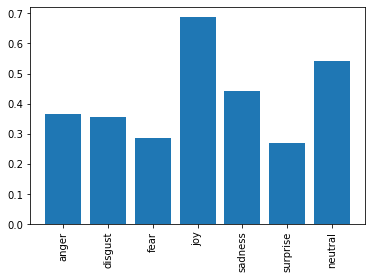

In [22]:
###### Using this threshold of 0.2, we can determine the F1 score for each individual emotion:
column_names = list(data.columns[6:])
threshold = 0.2
f1_scores = []
for i in range(0,7):
    emotion_prediction = y_pred[:,i]
    emotion_prediction[emotion_prediction>=threshold]=1
    emotion_prediction[emotion_prediction<threshold]=0
    emotion_test = y_test[:,i]
    precision = precision_score(emotion_test, emotion_prediction)
    recall = recall_score(emotion_test, emotion_prediction)
    f1 = f1_score(emotion_test, emotion_prediction)
    print("Emotion: {}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(column_names[i], precision, recall, f1))
    f1_scores.append(f1)
    

import matplotlib.pyplot as plt
fig = plt.figure()
plt.bar(column_names[0:7],f1_scores)
plt.xticks(rotation=90)
plt.show()

In [23]:
pred = y_pred.copy()
pred[pred>=0.2] = 1
pred[pred<0.2] =0
print("Average F1-Score across Multi-Lables: {}".format(f1_score(y_test, pred, average='micro')))

Average F1-Score across Multi-Lables: 0.5326492537313433
